In [97]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import shap
from sklearn.linear_model import LinearRegression
import seaborn as sns
import os
from joblib import dump, load
from nilearn import plotting
import statsmodels.api as sm
from sklearn.model_selection import StratifiedShuffleSplit

from scipy.stats import linregress
from sklearn.linear_model import Lasso

class BaseRegressor:
    def __init__(self,save_path=None, scaler=None, params=None, params_space=None, fit_params_search=None, model_params_search=None,fit_params_train=None, models_params_train=None, name_model=None):             
        
        self.scaler = scaler if scaler is not None else StandardScaler()
        self.params = params if params is not None else {}
        self.params_space = params_space if params_space is not None else {}
        self.fit_params_search = fit_params_search if fit_params_search is not None else {}
        self.model_params_search = model_params_search if model_params_search is not None else {}
        self.fit_params_train = fit_params_train if fit_params_train is not None else {}
        self.model_params_train = models_params_train if models_params_train is not None else {}

        self.save_path = save_path
        self.model_ml = None
        self.name_model = name_model
        self.model = None
        self.opt_model = None
        self.explainer = None

        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.residual_model = None


    def preprocess_data(self, X):        
        X_scaled = self.scaler.fit_transform(X)
        return pd.DataFrame(X_scaled, columns=X.columns)
    
    def set_data(self,X,y):        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=1)
           
    def search_best_model(self,  X=None, y=None, param_space_=None, n_iter_=10, n_jobs_=-1, scoring_metric='neg_mean_absolute_error', type_model=1):
       
        if X is None:
            X = self.X_train
        if y is None:
            y = self.y_train

        if param_space_ is None:
            param_space = self.params_space
        else:
            param_space = param_space_

        n_splits = 10
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=126)       
        
        if type_model == 1:
            model = self.model_ml(**self.model_params_search)
        if type_model == 2:
            model = self.model_ml 

        self.opt_model = BayesSearchCV(
            estimator=model,
            search_spaces=param_space,
            #fit_params=self.fit_param,
            cv=kf,
            n_iter=n_iter_,
            scoring=scoring_metric,
            n_jobs=n_jobs_,
            random_state=42,
            verbose=1
        )                
        self.opt_model.fit(X, y, **self.fit_params_search)
        best_params_return = dict(self.opt_model.best_params_)  

        return self.opt_model, best_params_return
    
    
    def trainer(self, df_CN, df_patient=None, n_splits=10, n_iterations=20, params_=None, type_model=1, scaler=2):
    
        if params_ is None:
            params = self.params
        else:
            params = params_
        
        # Preparar el dataframe de controles
        X_CN = df_CN.iloc[:, :-2]  # Features
        y_CN = df_CN.iloc[:, -2]   # Labels (Age)
        ID_CN = df_CN.iloc[:, -1]  # IDs
        results_per_fold_CN_train = []
        results_per_fold_CN_test = []

        # Inicializar resultados
        results = {'model': [],
                   'mean_X_train_kf':[],
                   'std_X_train_kf':[],
                   'slope': [],
                   'intercept': [],
                   }
        
        results_labels_df_CN_train = pd.DataFrame(columns=['y_labels','y_pred','y_pred_corrected','GAP', 'GAP_corrected', 'ID-unique'])
        results_labels_df_CN_test = pd.DataFrame(columns=['y_labels', 'y_pred', 'y_pred_corrected', 'GAP', 'GAP_corrected', 'ID-unique'])

        if df_patient is not None:
            results_per_fold_patient = [[] for _ in df_patient]
        else:
            results_per_fold_patient = []

        results_labels_patient = []

        # Inicializar resultados por fold para pacientes
        # Si lista_dfs no es None, crear dataframes para almacenar resultados de pacientes
        if df_patient is not None:
            for _ in df_patient:
                results_labels_patient.append(pd.DataFrame(columns=['y_labels', 'y_pred', 'y_pred_corrected', 'GAP', 'GAP_corrected','ID-unique']))
                #results_per_fold_pat.append({})  # Diccionario por cada grupo de pacientes
        
        # Bucle de iteraciones
        for i in range(n_iterations):
            # Crear validación cruzada para CN
            kf_CN = KFold(n_splits=n_splits, shuffle=True, random_state=i)
            kf_CN_splits = list(kf_CN.split(X_CN, y_CN))

            # Crear validación cruzada para cada dataframe de pacientes si lista_dfs no es None
            if df_patient is not None:
                kf_splits_list = [list(KFold(n_splits=n_splits, shuffle=True, random_state=i).split(df.iloc[:, :-2], df.iloc[:, -2])) for df in df_patient]

            for fold in range(n_splits):
                # Obtener índices de entrenamiento y prueba para CN
                train_index_CN, test_index_CN = kf_CN_splits[fold]
                X_train_kf_CN, X_test_kf_CN = X_CN.iloc[train_index_CN], X_CN.iloc[test_index_CN]
                y_train_kf_CN, y_test_kf_CN = y_CN.iloc[train_index_CN], y_CN.iloc[test_index_CN]
                id_train_kf_CN = ID_CN.iloc[train_index_CN]
                id_test_kf_CN = ID_CN.iloc[test_index_CN]

                # Escalar los datos de acuerdo con el parámetro scaler
                if scaler == 1:
                    # No escalar
                    X_train_kf_CN_scaled = X_train_kf_CN
                    X_test_kf_CN_scaled = X_test_kf_CN
                elif scaler == 2:
                    # Z-score scaling
                    mean_X_train_kf = X_train_kf_CN.mean()
                    std_X_train_kf = X_train_kf_CN.std()
                    X_train_kf_CN_scaled = (X_train_kf_CN - mean_X_train_kf) / std_X_train_kf
                    X_test_kf_CN_scaled = (X_test_kf_CN - mean_X_train_kf) / std_X_train_kf
                elif scaler == 3:
                    # MinMax scaling (manual)
                    min_X_train_kf = X_train_kf_CN.min()
                    max_X_train_kf = X_train_kf_CN.max()
                    X_train_kf_CN_scaled = (X_train_kf_CN - min_X_train_kf) / (max_X_train_kf - min_X_train_kf)
                    X_test_kf_CN_scaled = (X_test_kf_CN - min_X_train_kf) / (max_X_train_kf - min_X_train_kf)

                # Entrenar el modelo con CN
                if type_model == 1:
                    model = self.model_ml(**params, **self.model_params_train)
                if type_model == 2:
                    model = self.model_ml 
                model.fit(X_train_kf_CN_scaled, y_train_kf_CN)

                y_pred_CN_train = model.predict(X_train_kf_CN_scaled)
                gap_CN_train = y_pred_CN_train - y_train_kf_CN

                # Hacer predicciones para el conjunto de prueba de CN
                y_pred_CN_test = model.predict(X_test_kf_CN_scaled)
                gap_CN_test = y_pred_CN_test - y_test_kf_CN

                # Ajuste de GAP para CN
                slope, intercept, _, _, _ = linregress(y_train_kf_CN, gap_CN_train)
                corrected_gap_CN_train = gap_CN_train - (slope * y_train_kf_CN + intercept)
                corrected_gap_CN_test = gap_CN_test - (slope * y_test_kf_CN + intercept)
                y_pred_corrected_CN_test = y_pred_CN_test - (slope * y_test_kf_CN + intercept)
                y_pred_corrected_CN_train = y_pred_CN_train - (slope * y_train_kf_CN + intercept)

                # Guardar resultados de CN 
                temp_CN_df_test = pd.DataFrame({
                    'y_labels': y_test_kf_CN,
                    'y_pred': y_pred_CN_test,
                    'y_pred_corrected': y_pred_corrected_CN_test,
                    'GAP': gap_CN_test,
                    'GAP_corrected': corrected_gap_CN_test,
                    'ID-unique': id_test_kf_CN
                })
                temp_CN_df_train = pd.DataFrame({                    
                    'y_labels': y_train_kf_CN,
                    'y_pred': y_pred_CN_train,
                    'y_pred_corrected': y_pred_corrected_CN_train,
                    'GAP': gap_CN_train,
                    'GAP_corrected': corrected_gap_CN_train,
                    'ID-unique': id_train_kf_CN
                })

                results_labels_df_CN_train = pd.concat([results_labels_df_CN_train, temp_CN_df_train], ignore_index=True)
                results_per_fold_CN_train.append(temp_CN_df_train.copy())
                results_labels_df_CN_test = pd.concat([results_labels_df_CN_test, temp_CN_df_test], ignore_index=True)
                results_per_fold_CN_test.append(temp_CN_df_test.copy())

                # Procesar cada dataframe de pacientes si lista_dfs no es None
                if df_patient is not None:
                    for j, df in enumerate(df_patient):
                        train_index_pat, test_index_pat = kf_splits_list[j][fold]
                        X_train_pat = df.iloc[train_index_pat, :-2]
                        X_test_pat = df.iloc[test_index_pat, :-2]
                        y_test_pat = df.iloc[test_index_pat, -2]
                        id_test_pat = df.iloc[test_index_pat, -1]

                        # Escalar usando los parámetros de CN
                        X_test_pat_scaled = (X_test_pat - mean_X_train_kf) / std_X_train_kf

                        # Predicciones para el grupo de pacientes
                        y_pred_pat_test = model.predict(X_test_pat_scaled)
                        gap_pat = y_pred_pat_test - y_test_pat

                        # Ajuste de GAP para los pacientes
                        corrected_gap_pat = gap_pat - (slope * y_test_pat + intercept)
                        y_pred_corrected_pat = y_pred_pat_test - (slope * y_test_pat + intercept)

                        # Guardar resultados para cada grupo de pacientes
                        temp_pat_df = pd.DataFrame({
                            'y_labels': y_test_pat,
                            'y_pred': y_pred_pat_test,
                            'y_pred_corrected': y_pred_corrected_pat,
                            'GAP': gap_pat,
                            'GAP_corrected': corrected_gap_pat,
                            'ID-unique': id_test_pat
                        })
                        results_labels_patient[j] = pd.concat([results_labels_patient[j], temp_pat_df], ignore_index=True)
                        results_per_fold_patient[j].append(temp_pat_df.copy())  # Guardar en la lista simple

                # Guardar el modelo entrenado
                results['model'].append(model)
                if scaler == 2:  # Z-score scaling
                    results['mean_X_train_kf'].append(mean_X_train_kf)
                    results['std_X_train_kf'].append(std_X_train_kf)
                elif scaler == 3:  # MinMax scaling
                    results['mean_X_train_kf'].append(min_X_train_kf)
                    results['std_X_train_kf'].append(max_X_train_kf)
                    
                results['slope'].append(slope)
                results['intercept'].append(intercept)

        return results_labels_df_CN_train, results_labels_df_CN_test, results_labels_patient, results, results_per_fold_CN_train,results_per_fold_CN_test, results_per_fold_patient


    def test(self):
        pass

    def avg_list(self, df_list):
        results_avg = []
        for df in df_list:            
            df_avg = df.groupby('ID-unique').agg({
                'y_labels': 'mean',
                'y_pred': 'mean',
                'y_pred_corrected': 'mean',
                'GAP': 'mean',
                'GAP_corrected': 'mean'
            }).reset_index()
            results_avg.append(df_avg)
        return results_avg

        
    def predicter(self, X_test=None):
        if X_test is None:
            X_test = self.X_test
        y_pred = self.model.predict(X_test)
        return y_pred   



    def regression_metrics(self, y_true, y_pred):
        """
        Calcula las métricas de regresión: MAE, MSE, RMSE y R2.
        """
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        return mae, mse, rmse, r2

    def best_hyper(self, opt_model, num_best=10, num_max=400):
        """
        Obtiene los mejores hiperparámetros para las mejores puntuaciones de validación cruzada dentro de los primeros num_max resultados.
       
        """
        results = opt_model.cv_results_
        errors = results['mean_test_score'][:num_max]  # Considerar solo los primeros num_max resultados
        best_idx = np.argsort(errors)[-num_best:]  # Obtener los índices de las mejores puntuaciones
        best_hypers = []

        for idx in best_idx:
            hyper = {}
            for param, value in results['params'][idx].items():
                hyper[param] = value
            best_hypers.append(hyper)

        # Invertir el orden para que el mejor esté en el índice 0
        best_hypers = best_hypers[::-1]

        return best_hypers

    
    def calculate_simple_shap(self, X_train, X_test, model, random_seed=42):        
        try:
            self.explainer = shap.Explainer(model,X_train)
            shap_values = self.explainer.shap_values(X_test)
        except Exception as e:
            print("Fallo al usar shap.Explainer, intentando con shap.KernelExplainer:", e)
            try:
                np.random.seed(random_seed)
                self.explainer = shap.KernelExplainer(model.predict, shap.sample(X_train, 10), num_jobs=-1)
                shap_values = self.explainer.shap_values(X_test)
            except Exception as kernel_e:
                print("Fallo al usar shap.KernelExplainer:", kernel_e)
                return None, None 

        shap_sum = np.abs(shap_values).sum(axis=0)
        # Crear un diccionario para almacenar la suma de SHAP por característica
        shap_summary = {feature: shap_sum[i] for i, feature in enumerate(X_test.columns)}

        # Ordenar las características por su suma de SHAP
        shap_summary_sorted = sorted(shap_summary.items(), key=lambda x: x[1], reverse=True)

        # Imprimir el listado de importancia de características
        print("Importancia de características basada en suma de valores SHAP:")
        for feature, shap_sum in shap_summary_sorted:
            print(f"{feature}: {shap_sum}")
        
        return shap_values, shap_summary_sorted
    
    def calculate_multiple_shap(self, df_train, df_test, results_per_fold_train, results_per_fold_test, models_list, feature_col_range, iteration=20, kfolds_=10,  scaler=2, random_seed=42):
        shap_values_dict = {id_unique: [] for id_unique in df_test['ID-unique'].unique()}
        
        range_ = iteration*kfolds_
        
        for i in range(range_):

            # Train
            ID_train_fold = results_per_fold_train[i]['ID-unique']
            df_train_fold = df_train[df_train['ID-unique'].isin(ID_train_fold)]
            X_train_kf = df_train_fold.iloc[:, feature_col_range]  # Features
            y_train_kf = df_train_fold.iloc[:, -2]  # Labels

            # Test
            ID_test_fold = results_per_fold_test[i]['ID-unique']
            df_test_fold = df_test[df_test['ID-unique'].isin(ID_test_fold)]
            X_test_kf = df_test_fold.iloc[:, feature_col_range]  # Features
            y_test_kf = df_test_fold.iloc[:, -2]  # Labels

            if scaler == 1:
                # No escalar
                X_train_kf_scaled = X_train_kf
                X_test_kf_scaled = X_test_kf
            elif scaler == 2:
                # Z-score scaling
                mean_X_train_kf = X_train_kf.mean()
                std_X_train_kf = X_train_kf.std()
                X_train_kf_scaled = (X_train_kf - mean_X_train_kf) / std_X_train_kf
                X_test_kf_scaled = (X_test_kf - mean_X_train_kf) / std_X_train_kf
            elif scaler == 3:
                # MinMax scaling (manual)
                min_X_train_kf = X_train_kf.min()
                max_X_train_kf = X_train_kf.max()
                X_train_kf_scaled = (X_train_kf - min_X_train_kf) / (max_X_train_kf - min_X_train_kf)
                X_test_kf_scaled = (X_test_kf - min_X_train_kf) / (max_X_train_kf - min_X_train_kf)


            model_ = models_list[i]

            try:
                self.explainer = shap.Explainer(model_,X_train_kf_scaled)
                shap_values = self.explainer.shap_values(X_test_kf_scaled)
            except Exception as e:
                print("Fallo al usar shap.Explainer, intentando con shap.KernelExplainer:", e)
                try:
                    np.random.seed(random_seed)
                    self.explainer = shap.KernelExplainer(model_.predict, shap.sample(X_train_kf_scaled, 10), num_jobs=-1)
                    shap_values = self.explainer.shap_values(X_test_kf_scaled)
                except Exception as kernel_e:
                    print("Fallo al usar shap.KernelExplainer:", kernel_e)
                    return None, None 

            # SHAP calculation
            #explainer = shap.Explainer(model_, X_train_kf_scaled)
            #shap_values = explainer.shap_values(X_test_kf_scaled)

            # Store SHAP values
            for idx, id_unique in enumerate(df_test_fold['ID-unique']):
                shap_values_dict[id_unique].append(shap_values[idx])

        # Average SHAP values
        shap_values_avg_dict = {id_unique: np.mean(values, axis=0) for id_unique, values in shap_values_dict.items()}

        # Prepare SHAP summary matrix
        shap_values_avg_matrix = [shap_values_avg_dict[id_unique] for id_unique in df_test['ID-unique'].unique()]
        shap_values_avg_array = np.array(shap_values_avg_matrix)

        feature_names = X_test_kf_scaled.columns.tolist()

        shap_values_df = pd.DataFrame(shap_values_avg_array, columns=feature_names)
        shap_values_df['ID-unique'] = df_test['ID-unique'].unique()
        shap_values_df.set_index('ID-unique', inplace=True)

        # SHAP summary
        shap_sum = np.abs(shap_values_avg_array).sum(axis=0)
        shap_summary = {feature: shap_sum[i] for i, feature in enumerate(feature_names)}
        shap_summary_sorted = sorted(shap_summary.items(), key=lambda x: x[1], reverse=True)

        # Imprimir el listado de importancia de características
        print("Importancia de características basada en suma de valores SHAP:")
        for feature, shap_sum in shap_summary_sorted:
            print(f"{feature}: {shap_sum}")

        return shap_values_avg_array, shap_summary_sorted


    def shap_region(self, shap_summary_sorted, num_max=20):
        # Crear un diccionario para almacenar la suma de SHAP por región cerebral
        shap_por_region = {}

        # Recorrer la lista shap_summary_sorted
        for feature, shap_value in shap_summary_sorted[:num_max]:
            # Extraer la región cerebral (últimos dos textos separados por '_')
            region = feature.split('_')[-2] + '_' + feature.split('_')[-1]
            
            # Agregar la región cerebral al diccionario si no existe
            if region not in shap_por_region:
                shap_por_region[region] = 0.0
            
            # Sumar el valor SHAP al total de esa región cerebral
            shap_por_region[region] += shap_value
        
        max_value = max(shap_por_region.values())

        # Crear un diccionario para almacenar los valores normalizados
        resultado_normalizado = {}

        # Normalizar cada valor en el diccionario y almacenarlos en resultado_normalizado
        for region, suma_shap in shap_por_region.items():
            resultado_normalizado[region] = suma_shap / max_value

        # Ordenar shap_por_region y resultado_normalizado por valor descendente
        shap_por_region_sorted = {k: v for k, v in sorted(shap_por_region.items(), key=lambda item: item[1], reverse=True)}
        resultado_normalizado_sorted = {k: v for k, v in sorted(resultado_normalizado.items(), key=lambda item: item[1], reverse=True)}

        # Imprimir los valores normalizados ordenados
        for region, valor_normalizado in resultado_normalizado_sorted.items():
            print(f'{region}: {valor_normalizado:.6f}')

        return shap_por_region_sorted, resultado_normalizado_sorted

    

In [98]:
#C:\Users\felipe\OneDrive - Universidad Técnica Federico Santa María\Documentos

path=  'C:/Users/felipe/OneDrive - Universidad Técnica Federico Santa María/Documentos/Brain/'
#import sys
#sys.path.append(path) 
path_=  'C:/Users/felipe/OneDrive - Universidad Técnica Federico Santa María/Documentos/Brain/Brain_Model/'
import sys
sys.path.append(path_) 

In [119]:
from sklearn.linear_model import Lasso
#from base_regressor import BaseRegressor
from Plotter import Plotter
from skopt.space import Real, Categorical, Integer

class LassoRegressor(BaseRegressor):
    def __init__(self, save_path=None, scaler=None, params=None, params_space=None, fit_params_search=None, model_params_search=None, fit_params_train=None, model_params_train=None, name_model="Lasso"):
        super().__init__(save_path, scaler, params, params_space, fit_params_search, model_params_search, fit_params_train, model_params_train, name_model)

        self.model_ml = Lasso
        if params is None:
            self.params = {
                'alpha': 0.2,
                'max_iter': 10000,
                #'tol': 0.001
            }
        if params_space is None:
            self.params_space = {
                'alpha': Real(0.001, 10.0, prior='log-uniform'),
                'max_iter': Integer(100, 1000),
                'tol': Real(1e-5, 1e-2, prior='log-uniform')
            }


In [43]:
#72 features
features = ['Alpha2_canon_EPP_HPC_left', 'Alpha2_canon_EPP_HPC_right', 'Alpha2_canon_EPP_PARIET_left', 'Alpha2_canon_EPP_PARIET_right', 'Alpha2_canon_EPP_OCC_left', 'Alpha2_canon_EPP_OCC_right', 'Alpha2_canon_RPD_HPC_left', 'Alpha2_canon_RPD_HPC_right', 'Alpha2_canon_RPD_CING_left', 'Alpha2_canon_RPD_CING_right', 'Alpha2_canon_RPD_PARIET_left', 'Alpha2_canon_RPD_PARIET_right', 'Alpha2_canon_RPD_OCC_left', 'Alpha2_canon_RPD_OCC_right', 'High_subj_spec_EPP_HPC_left', 'High_subj_spec_EPP_HPC_right', 'High_subj_spec_EPP_CING_left', 'High_subj_spec_EPP_CING_right', 'High_subj_spec_EPP_PARIET_left', 'High_subj_spec_EPP_PARIET_right', 'High_subj_spec_EPP_OCC_left', 'High_subj_spec_EPP_OCC_right', 'High_subj_spec_RPD_HPC_left', 'High_subj_spec_RPD_HPC_right', 'High_subj_spec_RPD_CING_left', 'High_subj_spec_RPD_CING_right', 'High_subj_spec_RPD_PARIET_left', 'High_subj_spec_RPD_PARIET_right', 'High_subj_spec_RPD_OCC_left', 'High_subj_spec_RPD_OCC_right', 'Low_subj_spec_EPP_HPC_left', 'Low_subj_spec_EPP_HPC_right', 'Low_subj_spec_EPP_CING_left', 'Low_subj_spec_EPP_CING_right', 'Low_subj_spec_EPP_PARIET_left', 'Low_subj_spec_EPP_PARIET_right', 'Low_subj_spec_EPP_OCC_left', 'Low_subj_spec_EPP_OCC_right', 'Low_subj_spec_RPD_HPC_left', 'Low_subj_spec_RPD_HPC_right', 'Low_subj_spec_RPD_CING_left', 'Low_subj_spec_RPD_CING_right', 'Low_subj_spec_RPD_PARIET_left', 'Low_subj_spec_RPD_PARIET_right', 'Low_subj_spec_RPD_OCC_left', 'Low_subj_spec_RPD_OCC_right', 'TF_ORB_left', 'TF_ORB_right', 'TF_IFG_left', 'TF_IFG_right', 'TF_MFG_left', 'TF_MFG_right', 'TF_SFG_left', 'TF_SFG_right', 'TF_HPC_left', 'TF_HPC_right', 'TF_INS_left', 'TF_INS_right', 'IAF_ORB_left', 'IAF_ORB_right', 'IAF_IFG_left', 'IAF_IFG_right', 'IAF_MFG_left', 'IAF_MFG_right', 'IAF_SFG_left', 'IAF_SFG_right', 'IAF_HPC_left', 'IAF_HPC_right', 'IAF_INS_left', 'IAF_INS_right', 'IAF_OCC_left', 'IAF_OCC_right']

In [100]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import pickle


file_path_CN = f'{path}Brain_Age/CN_freq.xlsx'

df_CN = pd.read_excel(file_path_CN)


df_CN_filtrado = df_CN[(df_CN['Age'] >=20) & (df_CN['Age'] <= 90)].reset_index(drop=True)


X_CN = df_CN_filtrado[features]
y_CN = df_CN_filtrado["Age"]
ID_CN = df_CN_filtrado["ID-unique"]

scaler = StandardScaler()
scaler.fit(X_CN)

X_CN_scaled = scaler.transform(X_CN)

X_CN_scaled = pd.DataFrame(X_CN_scaled, columns=X_CN.columns)

df_concatenado_CN = pd.concat([X_CN, y_CN, ID_CN], axis=1, ignore_index=False)

In [120]:
model = LassoRegressor()
Plotters = Plotter()

In [7]:
#'neg_mean_absolute_error'
#'neg_mean_squared_error'
#'neg_root_mean_squared_error'
#'explained_variance'
#'r2'

opt_model, best_params = model.search_best_model (X=X_CN_scaled, y=y_CN, n_iter_=50, scoring_metric='neg_mean_absolute_error')


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

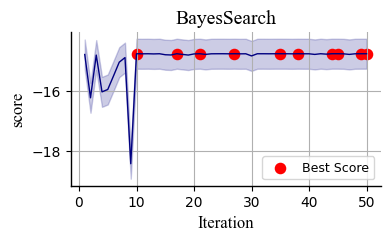

Top 1: Iteration 27, Score -14.764678104998103
Top 2: Iteration 44, Score -14.764719481816934
Top 3: Iteration 50, Score -14.764950589675726
Top 4: Iteration 17, Score -14.764950589675726
Top 5: Iteration 21, Score -14.764969535061061
Top 6: Iteration 49, Score -14.764974249653449
Top 7: Iteration 38, Score -14.76501089209778
Top 8: Iteration 45, Score -14.765022397003957
Top 9: Iteration 35, Score -14.765084532778221
Top 10: Iteration 10, Score -14.765135515138372


In [102]:
score = opt_model.cv_results_['mean_test_score'][:50]
Plotters.plot_iteration(y=score, title='BayesSearch', xlabel='Iteration', ylabel='score', legend_result=False, best_result=True, y_size=2, font='Times New Roman', weight='normal', mode=2, band_width=0.5)

In [103]:
best_params_ = model.best_hyper(num_best=10, opt_model=opt_model, num_max=50)
best_params_

[{'alpha': 0.012342903486803593, 'max_iter': 1000, 'tol': 0.01},
 {'alpha': 0.014006072931094325, 'max_iter': 1000, 'tol': 0.01},
 {'alpha': 0.001, 'max_iter': 1000, 'tol': 0.0002907841362756039},
 {'alpha': 0.001, 'max_iter': 1000, 'tol': 1e-05},
 {'alpha': 0.001, 'max_iter': 1000, 'tol': 0.01},
 {'alpha': 0.0010020369092584214,
  'max_iter': 977,
  'tol': 0.009330555754843466},
 {'alpha': 0.0010937797480173525,
  'max_iter': 995,
  'tol': 0.005608614537778128},
 {'alpha': 0.001104029715252696,
  'max_iter': 984,
  'tol': 1.3310788006962077e-05},
 {'alpha': 0.001, 'max_iter': 872, 'tol': 0.0026302964426619876},
 {'alpha': 0.0010340016434251915,
  'max_iter': 836,
  'tol': 0.0016743576591267016}]

In [104]:
from sklearn.model_selection import train_test_split
# Dividir el dataframe
df_train, df_test = train_test_split(df_concatenado_CN, test_size=0.2, random_state=42)

# Resultado: df_train y df_test son dataframes


In [105]:
results_labels_df_CN_train, results_labels_df_CN_val, results_labels_patient, results_model, results_per_fold_CN_train, results_per_fold_CN_val, results_per_fold_patient= model.trainer(df_CN=df_train, n_splits=10, n_iterations=1, params_=best_params_[0], scaler=2)

C:\Users\felipe\AppData\Local\Temp\ipykernel_13948\4020470439.py:207: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_labels_df_CN_train = pd.concat([results_labels_df_CN_train, temp_CN_df_train], ignore_index=True)
C:\Users\felipe\AppData\Local\Temp\ipykernel_13948\4020470439.py:209: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_labels_df_CN_test = pd.concat([results_labels_df_CN_test, temp_CN_df_test], ignore_index=True)


In [106]:
results_model

{'model': [Lasso(alpha=0.012342903486803593, tol=0.01),
  Lasso(alpha=0.012342903486803593, tol=0.01),
  Lasso(alpha=0.012342903486803593, tol=0.01),
  Lasso(alpha=0.012342903486803593, tol=0.01),
  Lasso(alpha=0.012342903486803593, tol=0.01),
  Lasso(alpha=0.012342903486803593, tol=0.01),
  Lasso(alpha=0.012342903486803593, tol=0.01),
  Lasso(alpha=0.012342903486803593, tol=0.01),
  Lasso(alpha=0.012342903486803593, tol=0.01),
  Lasso(alpha=0.012342903486803593, tol=0.01)],
 'mean_X_train_kf': [Alpha2_canon_EPP_HPC_left        0.006681
  Alpha2_canon_EPP_HPC_right       0.006323
  Alpha2_canon_EPP_PARIET_left     0.007252
  Alpha2_canon_EPP_PARIET_right    0.007346
  Alpha2_canon_EPP_OCC_left        0.006817
                                     ...   
  IAF_HPC_right                    9.355392
  IAF_INS_left                     9.460215
  IAF_INS_right                    9.492910
  IAF_OCC_left                     9.441745
  IAF_OCC_right                    9.422925
  Length: 72, dty

# Test

In [1]:
import pandas as pd

def process_test_data(df_test, results_model, n_folds=10):
    """
    Función para procesar datos de prueba con un modelo previamente entrenado.

    Parámetros:
    - df_test: DataFrame con los datos de prueba (incluyendo características, etiquetas y IDs).
    - results_model: Diccionario con los modelos entrenados y sus estadísticas (pendientes, interceptos, medias y desviaciones).
    - n_folds: Número de folds (por defecto 10).

    Retorna:
    - results_labels_df_CN_test: DataFrame con las predicciones y correcciones para cada fold.
    - results_per_fold_CN_test: Lista con los DataFrames generados por fold.
    """
    X_CN_test = df_test.iloc[:, :-2]  # Features
    y_CN_test = df_test.iloc[:, -2]   # Labels (Age)
    ID_CN_test = df_test.iloc[:, -1]  # Unique IDs

    # DataFrame para almacenar los resultados generales
    results_labels_df_CN_test = pd.DataFrame(columns=['y_labels', 'y_pred', 'y_pred_corrected', 'GAP', 'GAP_corrected', 'ID-unique'])
    results_per_fold_CN_test = []

    for fold in range(n_folds):
        slope = results_model['slope'][fold]
        intercept = results_model['intercept'][fold]
        mean_X_train_kf = results_model['mean_X_train_kf'][fold]
        std_X_train_kf = results_model['std_X_train_kf'][fold]

        # Escalado de los datos de prueba
        X_test_CN_scaled = (X_CN_test - mean_X_train_kf) / std_X_train_kf

        # Obtener el modelo del fold actual
        model_ = results_model['model'][fold]

        # Predicción
        y_pred_CN_test = model_.predict(X_test_CN_scaled)
        gap_CN_test = y_pred_CN_test - y_CN_test

        # Corrección de la predicción
        y_pred_corrected_CN_test = y_pred_CN_test - (slope * y_CN_test + intercept)
        corrected_gap_CN_test = gap_CN_test - (slope * y_CN_test + intercept)

        # Crear un DataFrame temporal con los resultados
        temp_CN_df_test = pd.DataFrame({
            'y_labels': y_CN_test,
            'y_pred': y_pred_CN_test,
            'y_pred_corrected': y_pred_corrected_CN_test,
            'GAP': gap_CN_test,
            'GAP_corrected': corrected_gap_CN_test,
            'ID-unique': ID_CN_test
        })

        # Concatenar los resultados del fold al DataFrame general
        results_labels_df_CN_test = pd.concat([results_labels_df_CN_test, temp_CN_df_test], ignore_index=True)
        results_per_fold_CN_test.append(temp_CN_df_test.copy())

    return results_labels_df_CN_test, results_per_fold_CN_test


In [ ]:
results_labels_df_CN_test, results_per_fold_CN_test = process_test_data(df_test, results_model)


In [109]:
X_CN_test = df_test.iloc[:, :-2]  # Features
y_CN_test = df_test.iloc[:, -2]   # Labels (Age)
ID_CN_test = df_test.iloc[:, -1]

results_labels_df_CN_test = pd.DataFrame(columns=['y_labels', 'y_pred', 'y_pred_corrected', 'GAP', 'GAP_corrected', 'ID-unique'])
results_per_fold_CN_test = []

for fold in range(10):
    slope=results_model['slope'][fold]
    intercept=results_model['intercept'][fold]
    mean_X_train_kf=results_model['mean_X_train_kf'][fold]
    std_X_train_kf=results_model['std_X_train_kf'][fold]

    X_test_CN_scaled = (X_CN_test - mean_X_train_kf) / std_X_train_kf

    model_ = results_model['model'][fold]


    y_pred_CN_test = model_.predict(X_test_CN_scaled)
    gap_CN_test = y_pred_CN_test - y_CN_test


    y_pred_corrected_CN_test = y_pred_CN_test - (slope * y_CN_test + intercept)
    corrected_gap_CN_test = gap_CN_test - (slope * y_CN_test + intercept)


    temp_CN_df_test = pd.DataFrame({
                        'y_labels': y_CN_test,
                        'y_pred': y_pred_CN_test,
                        'y_pred_corrected': y_pred_corrected_CN_test,
                        'GAP': gap_CN_test,
                        'GAP_corrected': corrected_gap_CN_test,
                        'ID-unique': ID_CN_test
                    })

    results_labels_df_CN_test = pd.concat([results_labels_df_CN_test, temp_CN_df_test], ignore_index=True)
    results_per_fold_CN_test.append(temp_CN_df_test.copy())
        

C:\Users\felipe\AppData\Local\Temp\ipykernel_13948\2926707731.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_labels_df_CN_test = pd.concat([results_labels_df_CN_test, temp_CN_df_test], ignore_index=True)


# Evaluación del modelo

In [110]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Lista de métricas
#metrics = ['mae', 'mse', 'rmse', 'r2']

# Diccionario para almacenar los resultados
#results = {'train': {m: [] for m in metrics}, 
#           #'val': {m: [] for m in metrics}, 
#           'test': {m: [] for m in metrics}}

metrics = ['mae', 'mse', 'rmse', 'r2']
results = {'train': {m: [] for m in metrics}, 
        'val': {m: [] for m in metrics}, 
        'test': {m: [] for m in metrics}}

# Función para calcular las métricas
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2}

# Recorrer los 10 folds
for fold_idx in range(10):
    fold_data_CN_train = results_per_fold_CN_train[fold_idx]
    fold_data_CN_val = results_per_fold_CN_val[fold_idx]
    fold_data_CN_test = results_per_fold_CN_test[fold_idx]

    # Obtener los valores de y_labels e y_pred_corrected
    y_true_1 = fold_data_CN_train['y_labels']
    y_pred_1 = fold_data_CN_train['y_pred']
    y_true_2 = fold_data_CN_val['y_labels']
    y_pred_2 = fold_data_CN_val['y_pred']
    y_true_3 = fold_data_CN_test['y_labels']
    y_pred_3 = fold_data_CN_test['y_pred']
    
    # Calcular métricas para el fold actual
    fold_metrics_1 = calculate_metrics(y_true_1, y_pred_1)
    fold_metrics_2 = calculate_metrics(y_true_2, y_pred_2)
    fold_metrics_3 = calculate_metrics(y_true_3, y_pred_3)

    # Guardar los resultados en el diccionario
    for metric in metrics:
        results['train'][metric].append(fold_metrics_1[metric])
        results['val'][metric].append(fold_metrics_2[metric]) 
        results['test'][metric].append(fold_metrics_3[metric]) 

# Imprimir resultados
#for metric in metrics:
#    print(f"{metric}: {results['train'][metric]}")

labels = ['train', 'val','test']

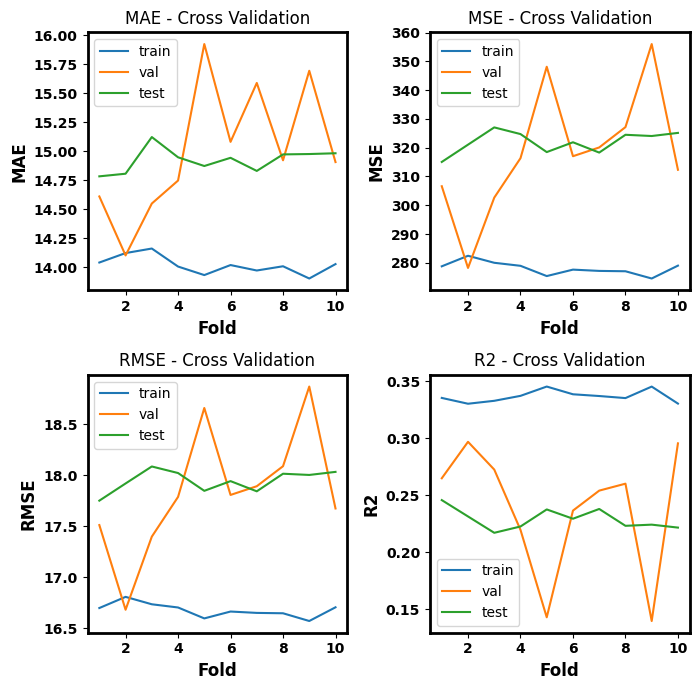

In [111]:
Plotters.plot_metricas_evaluacion(results, labels=labels, name_set='Cross Validation')

# Best Fold

In [112]:
mae_list = results['val']['mae']
min_mae_index = mae_list.index(min(mae_list))

y_labels_=results_per_fold_CN_test[min_mae_index]['y_labels']
y_pred_= results_per_fold_CN_test[min_mae_index]['y_pred_corrected']


                            OLS Regression Results                            
Dep. Variable:       y_pred_corrected   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     962.0
Date:                Sun, 20 Oct 2024   Prob (F-statistic):           7.59e-90
Time:                        16:08:46   Log-Likelihood:                -992.21
No. Observations:                 265   AIC:                             1988.
Df Residuals:                     263   BIC:                             1996.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7350      1.700      2.197      0.0

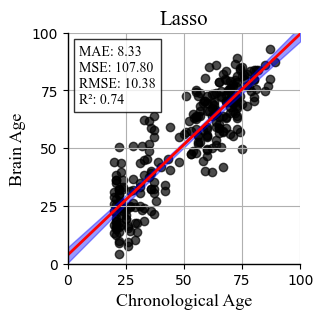

Error medio absoluto: 8.329553901209685
Error cuadrático medio: 107.80016329923839
Raíz del error cuadrático medio: 10.382685745954097
Coeficiente de determinación (R²): 0.7419025216750796


In [113]:
Plotters.plot_regresion(y=y_pred_,x= y_labels_, label_='Test Data',x_ticks_step=25,y_ticks_step=25,x_min_limit=0,y_min_limit=0,x_max_limit=100,y_max_limit=100,color='Black', title='Lasso',line_ideal=False,confidence_interval=True,  alpha=0.7,xlabel='Chronological Age',ylabel='Brain Age',color_confidence_interval='blue',alpha_confidence_interval=0.4,color_line_fit='red', details=True, font='Times New Roman', weight='normal', x_size=3,y_size=3, legend=False, fontsize=13, mode=2)

# SHAP

In [114]:
ID_fold = results_per_fold_CN_train[min_mae_index]['ID-unique']
df_train_fold = df_concatenado_CN[df_concatenado_CN['ID-unique'].isin(ID_fold)]

X_train_kf_CN = df_train_fold.iloc[:, :-2]  # Features
y_train_kf_CN = df_train_fold.iloc[:, -2]   # Labels (Age)
id_train_kf_CN = df_train_fold.iloc[:, -1]

mean_X_train_kf=results_model['mean_X_train_kf'][min_mae_index]
std_X_train_kf=results_model['std_X_train_kf'][min_mae_index]

best_model = results_model['model'][min_mae_index]

X_train_kf_CN_scaled= (X_train_kf_CN - mean_X_train_kf) / std_X_train_kf
X_test_CN_scaled = (X_CN_test - mean_X_train_kf) / std_X_train_kf



In [115]:
shap_values, shap_summary_sorted = model.calculate_simple_shap(X_train=X_train_kf_CN_scaled, X_test=X_test_CN_scaled, model=best_model)

Importancia de características basada en suma de valores SHAP:
Low_subj_spec_RPD_OCC_left: 3170.034671638372
High_subj_spec_EPP_OCC_left: 1753.3786301811306
Low_subj_spec_RPD_CING_left: 1750.7881684062702
High_subj_spec_RPD_OCC_left: 1266.8623807878594
Low_subj_spec_EPP_OCC_left: 1152.6702009984533
Low_subj_spec_EPP_CING_left: 1145.1193769024183
Alpha2_canon_EPP_OCC_left: 1079.8665984263325
Low_subj_spec_RPD_PARIET_left: 1063.686897749405
Alpha2_canon_RPD_OCC_left: 1018.968573554828
High_subj_spec_RPD_CING_left: 957.1678371836034
Low_subj_spec_EPP_HPC_left: 940.039646353735
Low_subj_spec_EPP_PARIET_left: 863.1194934319217
Alpha2_canon_EPP_HPC_left: 742.9082088517139
Alpha2_canon_RPD_CING_right: 685.4691330042178
Alpha2_canon_EPP_OCC_right: 670.1224236131657
Low_subj_spec_EPP_HPC_right: 664.8622480289981
High_subj_spec_RPD_HPC_right: 590.7724752313846
TF_MFG_right: 583.9647668052303
IAF_OCC_right: 570.9318422061891
TF_SFG_right: 531.2268098948705
IAF_IFG_right: 475.4075664624114
Alpha2_

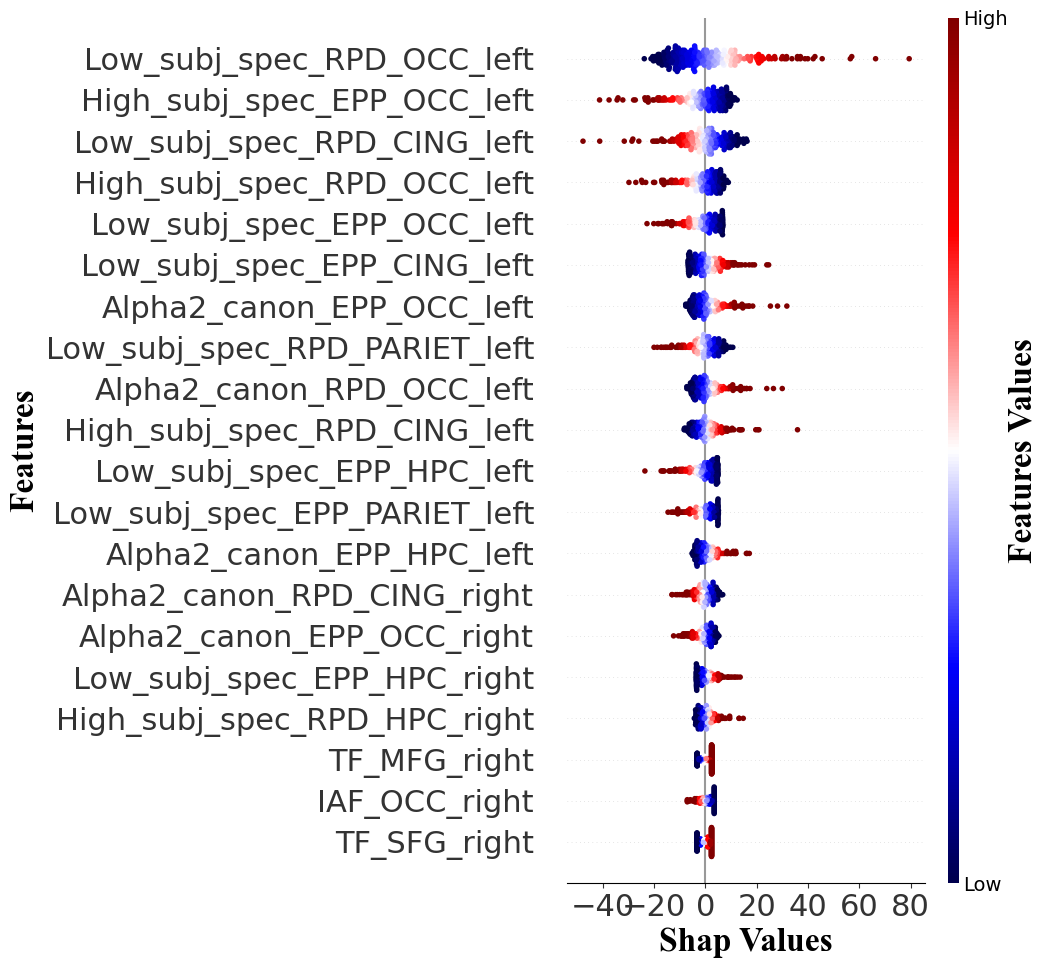

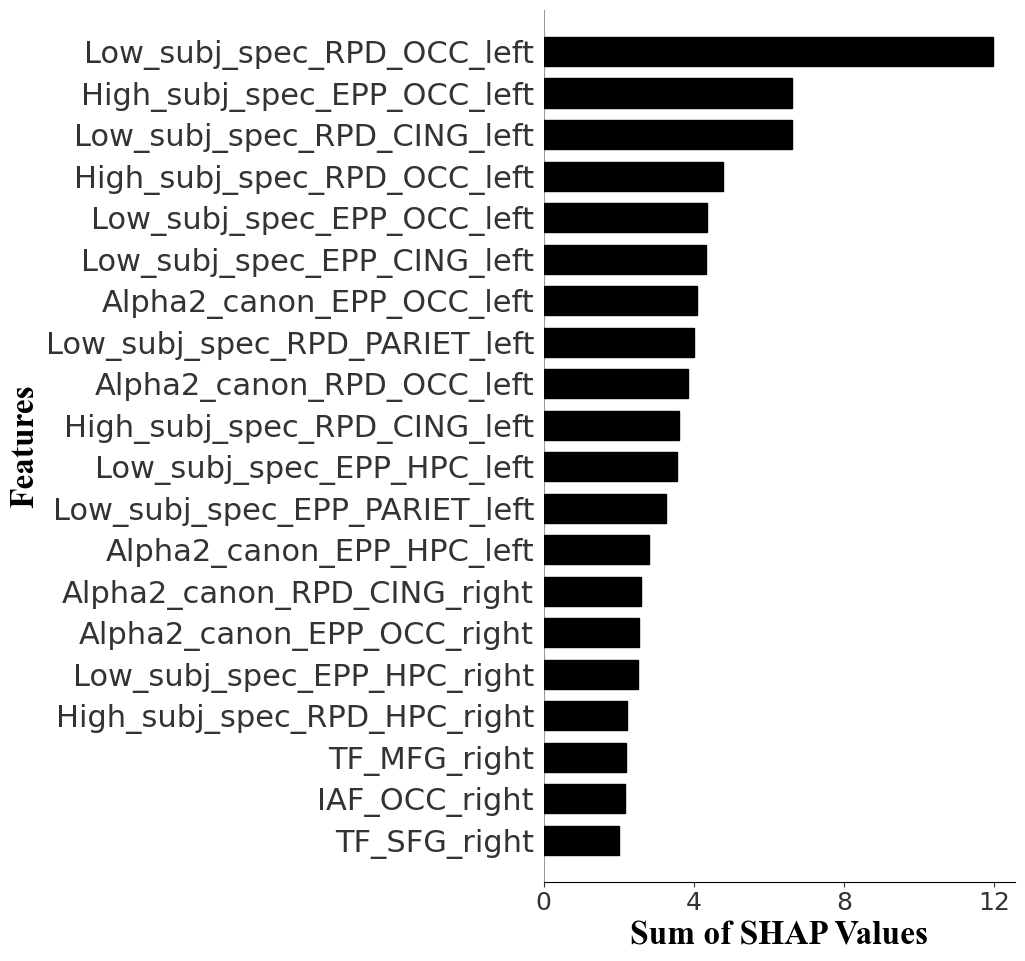

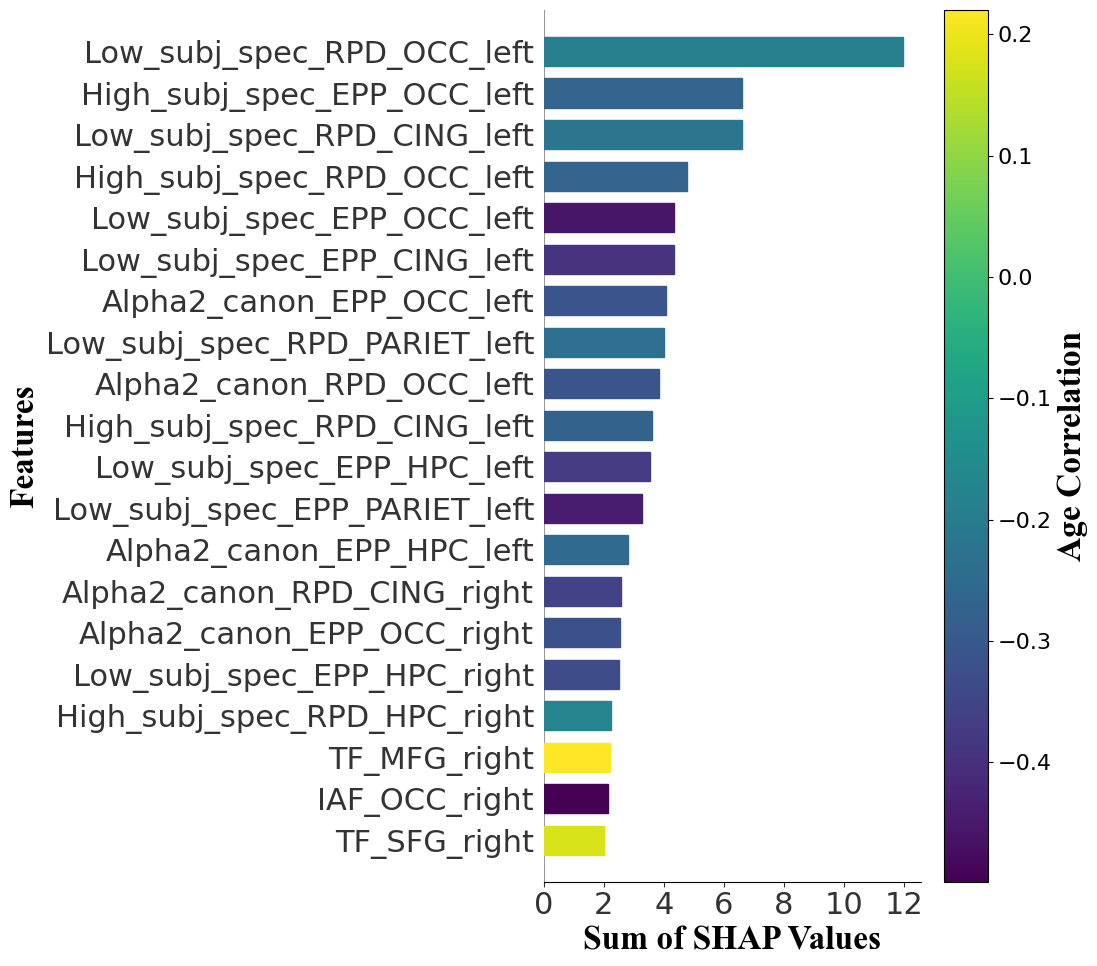

In [116]:
Plotters.plot_feature_importance(shap_values=shap_values,X_test=X_test_CN_scaled,y_test=y_CN_test, font= "Times New Roman", fontsize=24, xlabel1='Shap Values', xlabel2='Sum of SHAP Values',ylabel='Features', ylabel1='Features Values', ylabel2='Age Correlation')

In [ ]:
import shap
model_= best_model
explainer = shap.Explainer(model_, X_train_kf_CN_scaled)


In [ ]:
shap_values = explainer.shap_values(X_test_CN_scaled)
shap_sum = np.abs(shap_values).sum(axis=0)
shap_summary = {feature: shap_sum[i] for i, feature in enumerate(X_test_CN_scaled.columns)}
shap_summary_sorted = sorted(shap_summary.items(), key=lambda x: x[1], reverse=True)

